## **Exploratory Data Analysis**

This notebook serves as a prerequisite for modelling part of the project, we want to explore the relationships between attributes as well as data distributions  
and uncover what kind of data are we dealing with.

NOTE: Production-level visualizations will be iteratively developed after the drafts, this file serves as a draft of ideas for EDA.

In [3]:
import os
import sys

sys.dont_write_bytecode = True

import requests
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from dotenv import load_dotenv

load_dotenv()
sns.set_theme()
warnings.filterwarnings('ignore')

loading data

In [4]:
DATA_DIR = './Data/'
FILE = 'spotify_tracks_kaggle_weekly.csv'

In [5]:
data = pd.read_csv(DATA_DIR + FILE)

#### Popularity & Language distribution analysis

interestingly enough most of the songs are labeled with popularity = 0

<Axes: >

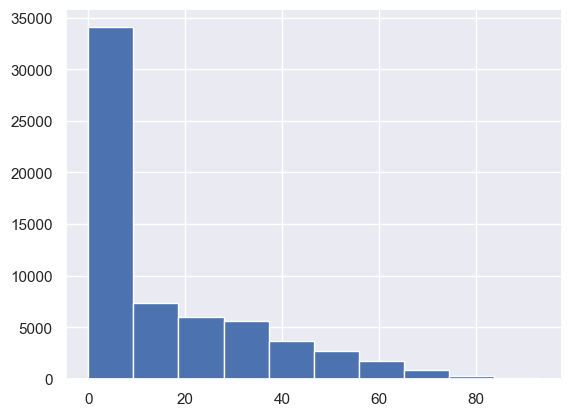

In [6]:
data['popularity'].hist()

<Axes: xlabel='language'>

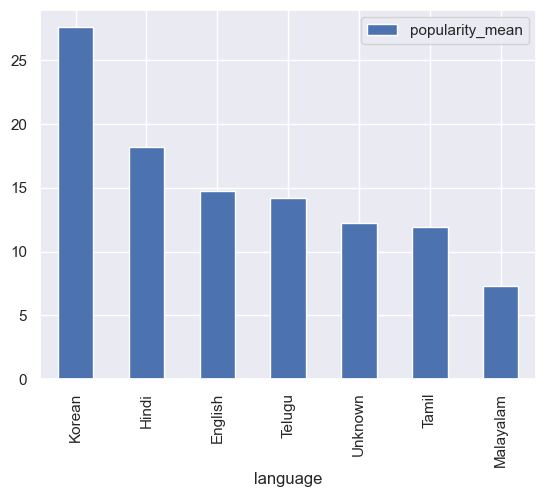

In [7]:
language_popularity = data.groupby('language').agg(
    popularity_mean = ('popularity', 'mean')
)

language_popularity.sort_values(by='popularity_mean', ascending=False).plot.bar()

Popularity across song release date - averaging aggregation

<Axes: xlabel='year'>

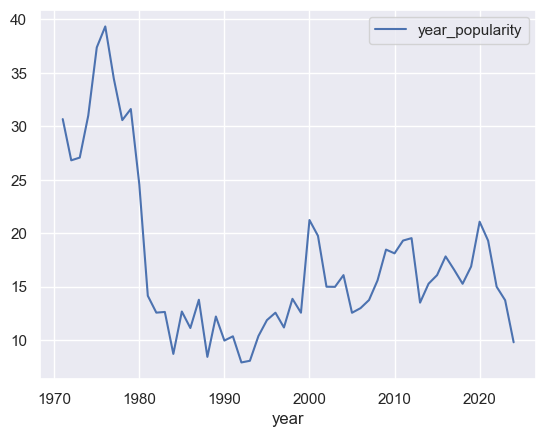

In [8]:
popularity_by_year = data.groupby('year').agg(
    year_popularity = ('popularity', 'mean')
)

popularity_by_year.plot()

we should investigate the counts bias -> we compare the counts of songs in that particular year to the popularity value to see if the popularity is not large
due to high count

Text(0.5, 0.98, 'Popularity based on year of release\nplot below describes counts of tracks in the corresponding year')

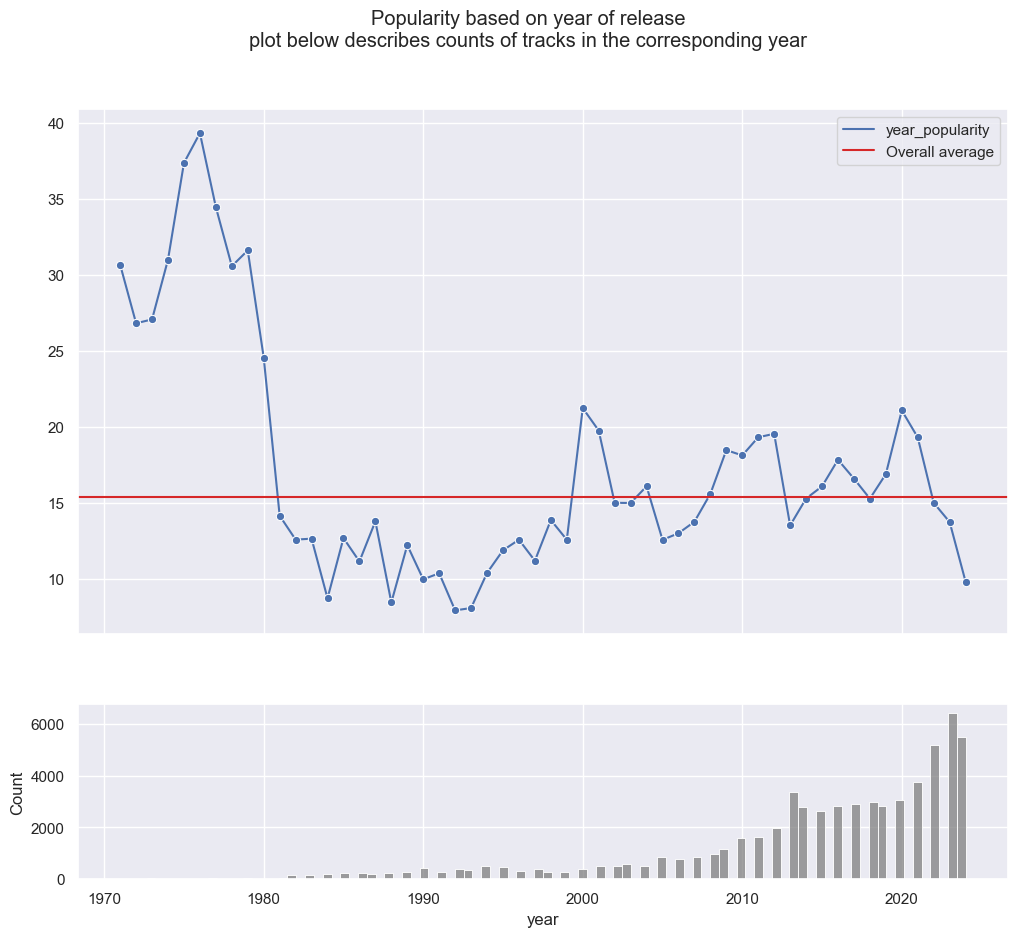

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

sns.lineplot(data=popularity_by_year, ax=ax[0], marker='o')
sns.histplot(data=data, x='year', color='grey')

ax[0].axhline(y=data['popularity'].mean(), color='tab:red', label='Overall average')

ax[0].legend()

fig.suptitle('Popularity based on year of release\nplot below describes counts of tracks in the corresponding year')

There could be bias due to the very strong imbalance of counts against the aggregated values.

Although not uniform, language distribution is roughly balanced with english not having overwhelming majority.

<Axes: xlabel='language'>

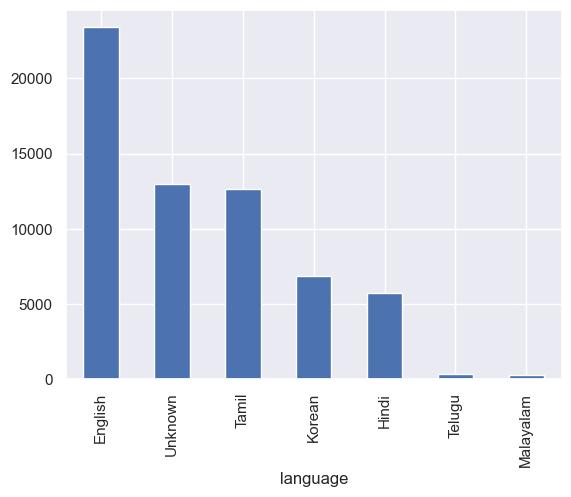

In [10]:
data['language'].value_counts().plot.bar()

### Distribution analysis

In [11]:
numeric_data = data[data.columns[data.dtypes != object]]
categorical_data = data[data.columns[data.dtypes == object]]

In [12]:
print(numeric_data.shape)
print(categorical_data.shape)

(62317, 15)
(62317, 7)


We will analyse the distribution estimation together with some other transformations which could be useful in production modelling.

Input distribution will be tested against:

1. Logarithmic transform
2. Square root transform

In [34]:
def custom_log_transform(X, epsilon=None):

    if epsilon is None:
        epsilon = abs(X.min()) + 1

    X_log = np.log(X + epsilon)

    return X_log


def custom_sqrt_transform(X, epsilon=None):

    if epsilon is None:
        epsilon = abs(X.min()) + 1

    X_sqrt = np.sqrt(X + epsilon)

    return X_sqrt

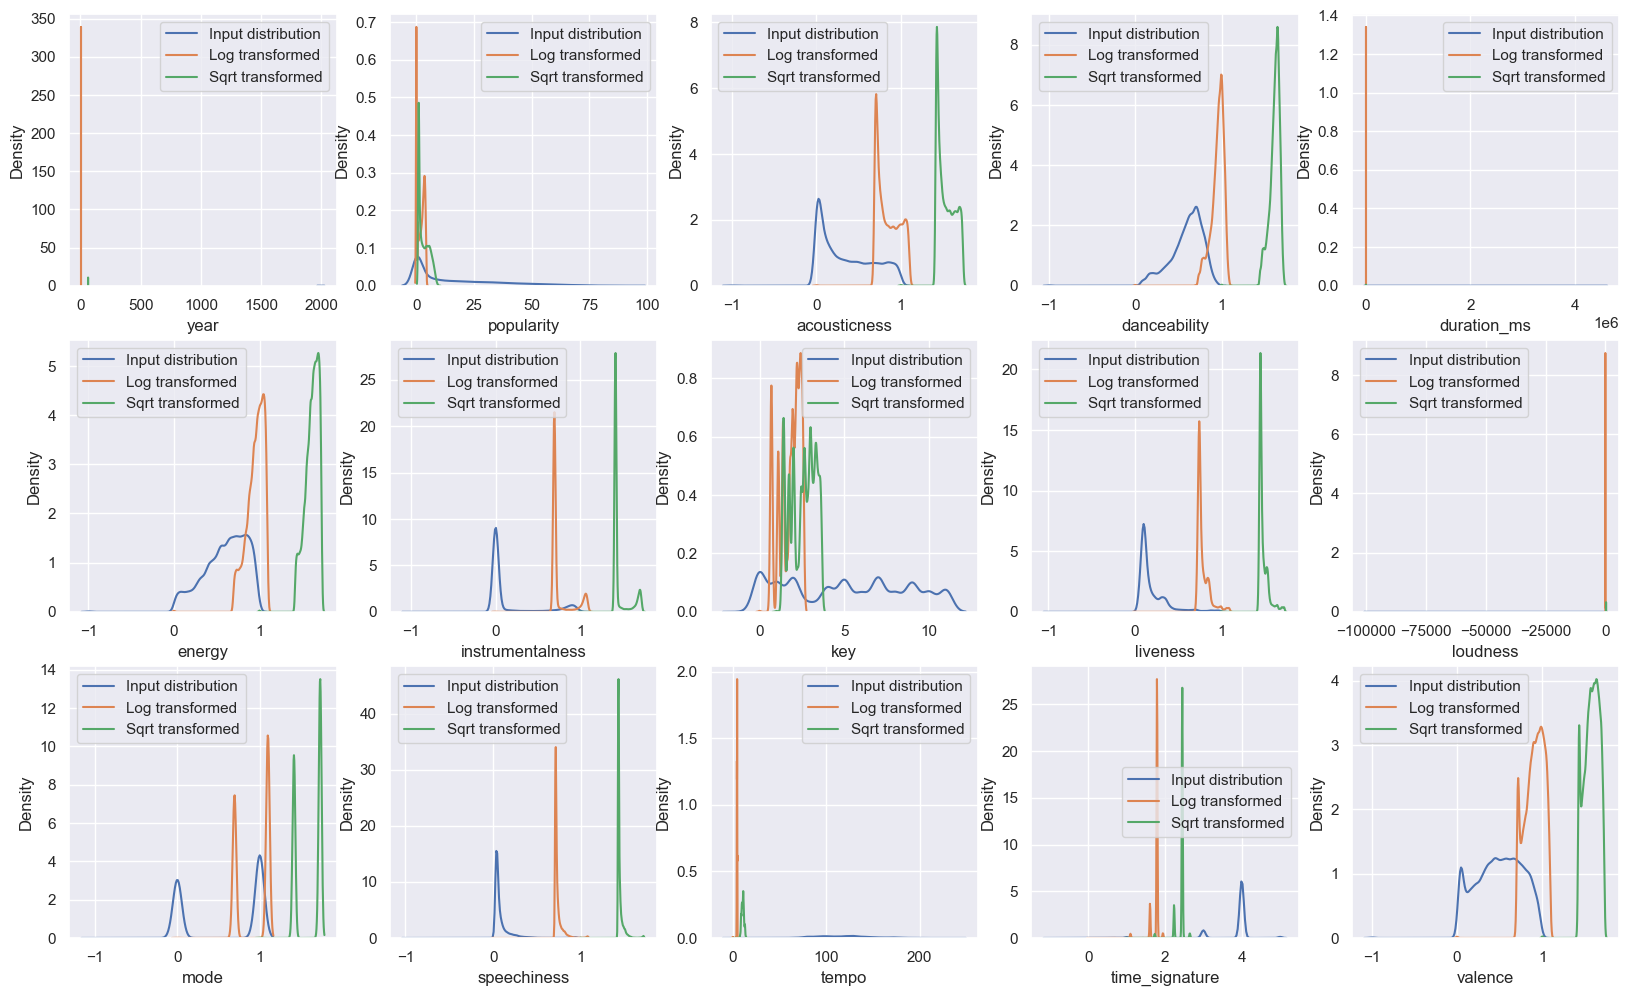

In [39]:
fig, axs = plt.subplots(3, 5, figsize=(20, 12))

axs = axs.flatten()

for i, col in enumerate(numeric_data.columns):
    
    column = numeric_data[col]

    sns.kdeplot(data=column, ax=axs[i], label='Input distribution')
    sns.kdeplot(data=custom_log_transform(column), ax=axs[i], label='Log transformed')
    sns.kdeplot(data=custom_sqrt_transform(column), ax=axs[i], label='Sqrt transformed')

    axs[i].legend()

Interestingly enough, transformations did not improve the data distributions... analysis of input distributions could be useful (wether we are dealing with predefined ranges for example which cannot have outliers)

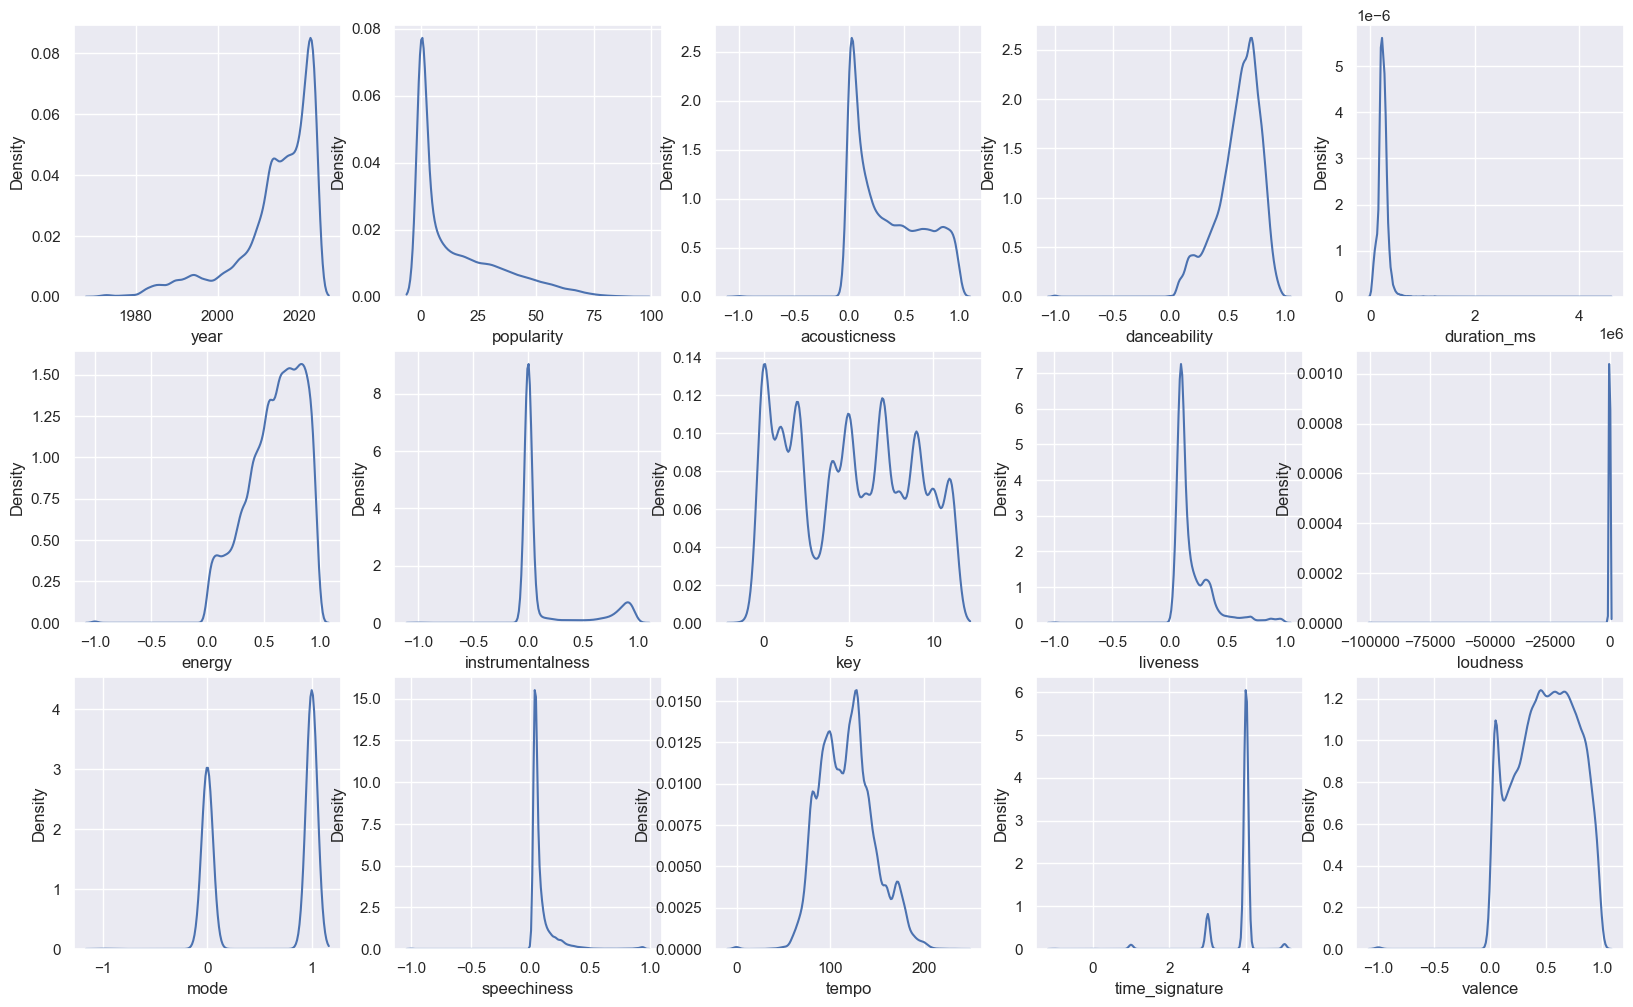

In [41]:
fig, axs = plt.subplots(3, 5, figsize=(20, 12))

axs = axs.flatten()

for i, col in enumerate(numeric_data.columns):
    
    column = numeric_data[col]

    sns.kdeplot(data=column, ax=axs[i], label='Input distribution')
    #sns.kdeplot(data=custom_log_transform(column), ax=axs[i], label='Log transformed')
    #sns.kdeplot(data=custom_sqrt_transform(column), ax=axs[i], label='Sqrt transformed')

    

categorical columns distribution analysis, we will also remove all columns wich are unique or have % variance above certain treshold

In [14]:
variance_treshold = 0.95

In [15]:
categorical_data.apply(lambda x: x.nunique() / x.shape[0])

track_id       0.998748
track_name     0.666287
artist_name    0.200796
artwork_url    0.338752
album_name     0.319303
track_url      0.998748
language       0.000112
dtype: float64

In [19]:
for i, col in enumerate(categorical_data.columns):

    column = categorical_data[col]

    if column.is_unique:
        print(col, "is unique -> will skip calculation -> column to be DROPPED")
        continue

    col_variance = column.nunique() / column.shape[0]

    if col_variance >= variance_treshold:
        print(col, f"has variance var={col_variance} above treshold={variance_treshold} --> skipping --> column to be DROPPED (further analysis whether drop should be executed is required)")
        continue


track_id has variance var=0.9987483351252467 above treshold=0.95 --> skipping --> column to be DROPPED (further analysis whether drop should be executed is required)
track_url has variance var=0.9987483351252467 above treshold=0.95 --> skipping --> column to be DROPPED (further analysis whether drop should be executed is required)


#### Interquantile range analysis - outliers

In [57]:
print(numeric_data.shape)

(62317, 15)


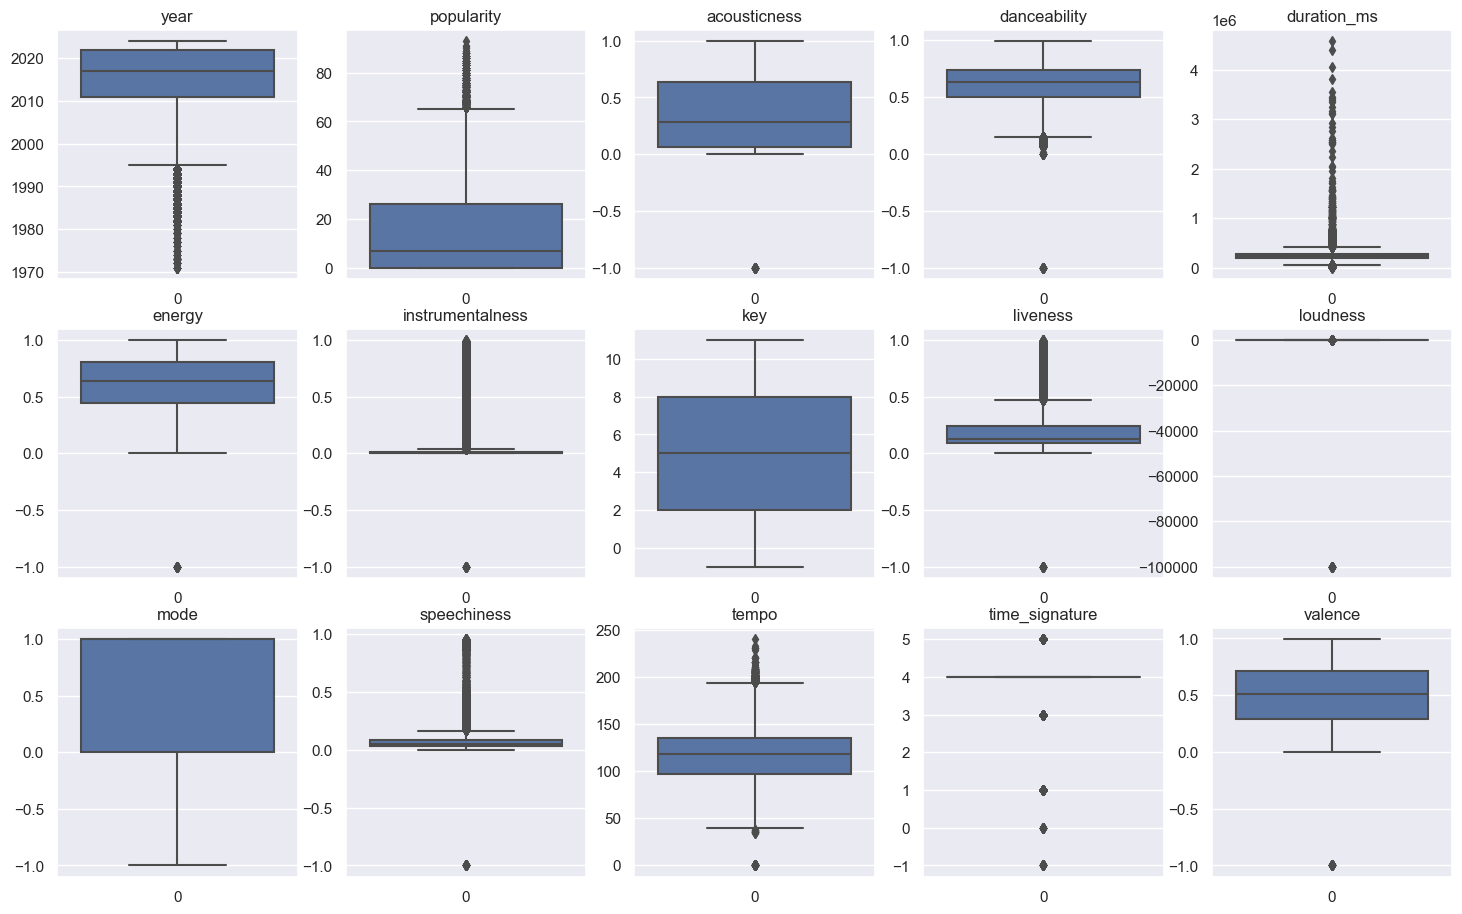

In [69]:
fig, ax = plt.subplots(3, 5, figsize=(18, 11))

ax = ax.flatten()

for i, col in enumerate(numeric_data.columns):

    column = numeric_data[col]

    sns.boxplot(data=column, ax=ax[i])
    ax[i].set_title(col)

outiers are present in the dataset

### Correlation analysis

<Axes: >

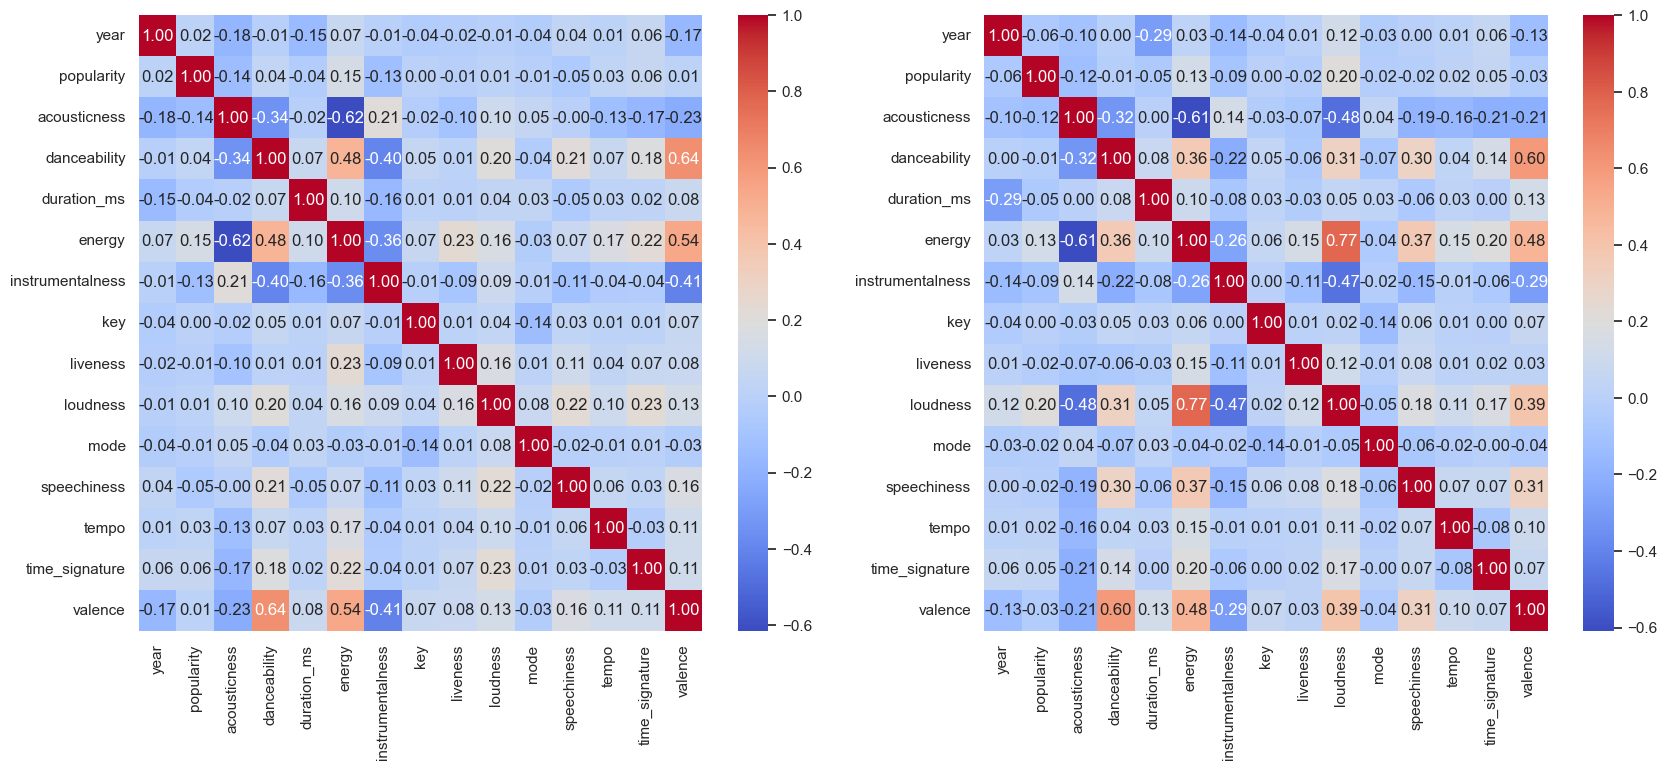

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

pearson = numeric_data.corr(method='pearson')
spearman = numeric_data.corr(method='spearman')

sns.heatmap(pearson, annot=True, fmt='.2f', cmap='coolwarm', ax=axs[0])
sns.heatmap(spearman, annot=True, fmt='.2f', cmap='coolwarm', ax=axs[1])